# Week 2 Team 7

In [2]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, classification_report, confusion_matrix, recall_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
import math
from itertools import islice
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from pykernels import GeneralizedHistogramIntersection

<h2>Read train and test files</h2>

<h3>Functions:</h3>
<ul>
    <li><b>list_dir():</b> obtain the labels of the classes from the directory names.</li>
    <li><b>get_label_path():</b> get paths of all the images of the dataset and their label.</li>
    <li><b>getData():</b> get paths of all images of train and test.</li>
</ul>

In [3]:
paths = {}

paths['trainImages'] = "./train/"
paths['testImages'] = "./test/"

#IN: base directory of images
#OUT: subdirectories/classes of images
def list_dir(path_dir):
    f = []
    for (dirpath, dirnames, filenames) in os.walk(path_dir):
        f.extend(dirnames)
        break
    return f

#IN: base directory off images
#OUT: directories and filenames of images
def get_label_path(path_dir):
    path_label = list_dir(path_dir)
    listImages ={}
     
    for label in path_label:
        
        # Import Data from directories
        for filename in os.listdir(path_dir + label):
            if filename.endswith(".jpg"):
                listImages[path_dir + label + '/'+ filename] = label
    return listImages

#OUT: train and test filenames
def getData():
    train = get_label_path(paths['trainImages'])
    test = get_label_path(paths['testImages'])
    return train, test

<H3>Cross Validation Variant</H3>

In order to avoid depending on a correct selection of the train and test data sets, we used cross validation technique.    


In [4]:
#IN: Train samples, number of splits
#OUT: Train and validation batches
def crossValidation(train, splits=2):
    X = np.array(list(train.keys()))
    y = np.array(list(train.values()))
    
    X_train = []
    X_validation = []
    y_train = []
    y_validation = []
    
    skf = StratifiedKFold(n_splits=splits)
    for train_index, validation_index in skf.split(X, y):
        X_train.append(X[train_index])
        X_validation.append(X[validation_index])
        y_train.append(y[train_index])
        y_validation.append(y[validation_index])

    return X_train, y_train, X_validation, y_validation

<h2>Create SIFT object detector and descriptor</h2>
We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together.

<h3>Function:</h3>
<ul>
    <li><b>numFeaturesIteration():</b> reads the image, converting it to gray, and applies the SIFT detector to fins the descriptors of the image.</li>
</ul>

<h3>Variables:</h3>
<ul>
    <li><b>Train_descriptors:</b> list of all the descriptors of each image.</li>
    <li><b>D:</b> stack of the descriptors of all the images.</li>
    <li><b>SIFTdescriptor:</b> class for extracting keypoints and computing descriptors using SIFT.</li>
</ul>

In [5]:
# IN: Number of features
# OUT: Sift Object
def createSift(numFeatures=0):
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=numFeatures)
    return sift


# IN: Image, SIFT
# OUT: Descriptor of Image
def siftDescriptors(image, sift):
    _, des = sift.detectAndCompute(image, None)
    return des


# IN: Image, SIFT, Scale, Step
# OUT: Descriptor of Image
def denseSiftDescriptors(image, sift, scale, step):
    kps = []
    for x in range(0, image.shape[1], step):
        for y in range(0, image.shape[0], step):
            if (scale == 0):
                scale = step * random.uniform(1, 3)
            kp = cv2.KeyPoint(x, y, scale)
            kps.append(kp)
    _, des = sift.compute(image, kps)
    return des


# IN: Descriptor numpy array
# OUT: Descriptor Stacked list
def stackDescriptors(descriptorsList):
    stackedDescriptors = np.vstack(descriptorsList)
    return stackedDescriptors


# IN: Dictionary of Images and Labels
# OUT: Descriptor Stacked List
def getDescriptors(X_Data, sift, isPca=False, isDense=False, scale=0, step=0):
    descriptors = []
    for filename in X_Data:
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
        
        if(isDense):
            des = denseSiftDescriptors(gray, sift, scale, step)
        else:
            des = siftDescriptors(gray, sift)
        if (isPca):
            descriptors.append(dimensionalityReduction(des, 2))
        else:
            descriptors.append(des)
    descriptors = normalizeDescriptors(descriptors)
    D = stackDescriptors(descriptors)
    return D, descriptors

In [6]:
# IN: Descriptors
# OUT: Normalized descriptors
def normalizeDescriptors(descriptors):
    scaled_descriptors = []
    imp = Imputer(strategy='mean', axis=1)
    for i in range(len(descriptors)):
        cleaned_descriptor = imp.fit_transform(descriptors[i])
        scaled_descriptors.append(preprocessing.scale(cleaned_descriptor))
    return scaled_descriptors

<h3>Spatial Pyramids</h3>

In [7]:
def getImageFeaturesSPM(L, set, codebook, sift, k):
    visual_words = []
    for filename in set:
#         print filename
        ima = cv2.imread(filename)
        img = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)

        W = img.shape[1]
        H = img.shape[0]
        h = []
        for l in range(L + 1):
            w_step = math.floor(W / (2 ** l))
            h_step = math.floor(H / (2 ** l))
            x, y = 0, 0
            for i in range(1, 2 ** l + 1):
                x = 0
                for j in range(1, 2 ** l + 1):
                    desc = denseSiftDescriptors(img[y:int(y + h_step), x:int(x + w_step)], sift, scale, step)
                    list_des = [desc]
                    predict = predictDescriptorsClusters(list_des, codebook, k)
                    histo = predict.ravel()
                    weight = 2 ** (l - L)
                    h.append(weight * histo)
                    x = int(x + w_step)
                y = int(y + h_step)

        hist = np.array(h).ravel()
        # normalize hist
        dev = np.std(hist)
        hist -= np.mean(hist)
        hist /= dev
        visual_words.append(hist)
    return visual_words

<H3> Declare Representation Spaces</H3>

In [8]:
def dimensionalityReduction(parsedDescriptors, numComponents=2):
    parsedDescriptors = np.transpose(parsedDescriptors)
    pca = PCA(n_components=numComponents)
    pca.fit(parsedDescriptors)
    reducedParsedDescriptors = pca.components_
    reducedParsedDescriptors = np.transpose(reducedParsedDescriptors)
    return reducedParsedDescriptors


def setRepresentationSpaceCentroids(parsedDescriptors, numClusters = 128):
    codebook = MiniBatchKMeans(n_clusters=numClusters, verbose=False, batch_size=numClusters * 20,compute_labels=False,
                               reassignment_ratio=10**-4, random_state=42)
    codebook.fit(parsedDescriptors)
    return codebook


def predictDescriptorsClusters(descriptorsList, codebook, numClusters=128):
    visual_words = np.zeros((len(descriptorsList), numClusters), dtype=np.float32)
    for i in range(len(descriptorsList)):
        words = codebook.predict(descriptorsList[i])
        visual_words[i, :] = np.bincount(words, minlength=numClusters)
    return visual_words

<H3>Predict Data</H3>

In [55]:
def scaleData(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

def LinearSVM(y_train_Split, visual_words,C):
    scaled_visual_words = scaleData(visual_words)
    lsvm = LinearSVC(C=C)
    lsvm.fit(visual_words, list(y_train_Split))
    return lsvm

def rbfSVM(y_train_Split, visual_words,C):
    scaled_visual_words = scaleData(visual_words)
    rbf_svm = SVC(kernel='rbf',C=C)
    rbf_svm.fit(visual_words, list(y_train_Split))
    return rbf_svm

# IN: 
def histIntersectionSVM(y_train_Split, visual_words,C):
    scaled_visual_words = scaleData(visual_words)
    rbf_svm = SVC(kernel=GeneralizedHistogramIntersection(),C=C)
    rbf_svm.fit(visual_words, list(y_train_Split))
    return rbf_svm

def fitNearestNeighbours(y_train_Split, numNeighbours, visual_words, metric):
    knn = KNeighborsClassifier(n_neighbors=numNeighbours,n_jobs=-1,metric=metric)
    knn.fit(visual_words, list(y_train_Split))
    return knn

<H3>Metrics Of Evaluations</H3>

In [10]:
def getAccuracy(y_validation_Split, classifier, visual_words):
    accuracy = 100 * classifier.score(visual_words, list(y_validation_Split))
    return accuracy


def getPrecision(y_validation_Split, visual_words):
    precision = precision_score(list(y_validation_Split), visual_words)
    return precision


def getRecall(y_validation_Split, visual_words):
    recall = recall_score(list(y_validation_Split), visual_words)
    return recall


def getF1Score(visual_words):
    precision = getPrecision(visual_words)
    recall = getRecall(visual_words)
    F1 = 2 * (precision * recall) / (precision + recall)
    return F1

<h1> Start Sequency of operations </h1>

<H3>Obtain Descriptors</H3>

In [11]:
def getAllDescriptors(X_train_Split, X_validation_Split, isPca, isDense, numFeatures, scale, step):
    if (isDense):
        numFeatures = 0
    sift = createSift(numFeatures)
    D_train, desciptors_train = getDescriptors(X_train_Split, sift, isPca, isDense, scale, step)
    D_test, desciptors_test = getDescriptors(X_validation_Split, sift, isPca, isDense, scale, step)
    return D_train, D_test, desciptors_train, desciptors_test, sift

<H3>Train Cluster</H3>

In [56]:
def getTrainedCluster(y_train_Split, D, numClusters, descriptors, numNeighbours, distanceMetric, classifier,C):
    codebook = setRepresentationSpaceCentroids(D, numClusters)
    visual_words = predictDescriptorsClusters(descriptors, codebook, numClusters)
    if (classifier == "KNN"):
        knn = fitNearestNeighbours(y_train_Split, numNeighbours, visual_words, distanceMetric)
    elif (classifier == "LinearSVM"):
        knn = LinearSVM(y_train_Split, visual_words,C)
    elif (classifier == "RBFSVM"):
        knn = rbfSVM(y_train_Split, visual_words,C)
    elif (classifier == "histSVM"):
        knn = histIntersectionSVM(y_train_Split, visual_words,C)
    else:
        print(classifier, " Is undefinied.")
    return codebook, knn

<H3>Predict With Test</H3>

In [57]:
def getResults(y_validation_Split, knn, descriptorsTest, codebook, numClusters):
    visual_words_test = predictDescriptorsClusters(descriptorsTest, codebook, numClusters)
    accuracy = getAccuracy(y_validation_Split, knn, visual_words_test)
    return accuracy

<h1> Main Pipeline of executions </h1>

In [58]:
def main(classifier, isDense, isPca, numClusters, numNeighbours, scale, step, distanceMetric, numFeatures, splits,C=1.0):
    train, test = getData()
    X_train, y_train, X_validation, y_validation = crossValidation(train, splits)
    accuracy = 0
    accuracy_SPM = 0
    for X_train_Split, y_train_Split, X_validation_Split, y_validation_Split in zip(X_train, y_train, X_validation,
                                                                                    y_validation):
        D_train, D_test, descriptors_train, descriptors_test, sift = getAllDescriptors(X_train_Split, X_validation_Split,
                                                                                 isPca, isDense, numFeatures, scale, step)

        codebook, knn = getTrainedCluster(y_train_Split, D_train, numClusters, descriptors_train, numNeighbours, distanceMetric,
                                          classifier,C)

        accuracy = accuracy + getResults(y_validation_Split, knn, descriptors_test, codebook, numClusters)

        train_histo = getImageFeaturesSPM(pyramid_levels, X_train_Split, codebook, sift, numClusters)
        test_histo = getImageFeaturesSPM(pyramid_levels, X_validation_Split, codebook, sift, numClusters)
        if (classifier == "KNN"):
            knn = fitNearestNeighbours(y_train_Split, numNeighbours, train_histo, distanceMetric)
        elif (classifier == "LinearSVM"):
            knn = LinearSVM(y_train_Split, train_histo,C)
        elif (classifier == "RBFSVM"):
            knn = rbfSVM(y_train_Split, train_histo,C)
        elif (classifier == "histSVM"):
            knn = histIntersectionSVM(y_train_Split, train_histo,C)
        else:
            print(classifier, " Is undefinied.")

        accuracy_SPM = accuracy_SPM + getAccuracy(y_validation_Split, knn, test_histo)

    return accuracy / splits, accuracy_SPM/splits

In [29]:
scales = list(range(1,10))
pyr1_scale_linear = np.zeros(len(scales))
pyr2_scale_linear = np.zeros(len(scales))

classifier = "LinearSVM"
isDense = True
isPca = False
numClusters = 96
numNeighbours = 27
scale = 2
step = 8
distanceMetric = "euclidean"
numFeatures = 0
splits = 5
pyramid_levels = 2
for i in range(len(scales)):
    pyr1_scale_linear[i], pyr2_scale_linear[i] = main(classifier, isDense, isPca, numClusters, numNeighbours, scale, step, distanceMetric, numFeatures, splits)
    print("Scale = ", scales[i], " Piramids lvl 1= ", pyr1_scale_linear[i], " Piramids lvl 2= ", pyr2_scale_linear[i])

Scale =  1  Piramids lvl 1=  51.010348935687304  Piramids lvl 2=  71.9797259220492
Scale =  2  Piramids lvl 1=  59.37547312612693  Piramids lvl 2=  75.22590520756557
Scale =  3  Piramids lvl 1=  64.52240078376974  Piramids lvl 2=  75.8588486842701
Scale =  4  Piramids lvl 1=  61.41436667312564  Piramids lvl 2=  74.95815352928784
Scale =  5  Piramids lvl 1=  63.30555540866916  Piramids lvl 2=  71.97272371452769
Scale =  6  Piramids lvl 1=  64.23860259119684  Piramids lvl 2=  73.57061884850319
Scale =  7  Piramids lvl 1=  67.55266744295123  Piramids lvl 2=  71.1215000763608
Scale =  8  Piramids lvl 1=  66.48627997312582  Piramids lvl 2=  67.49732423281536
Scale =  9  Piramids lvl 1=  67.55999723531625  Piramids lvl 2=  68.89096463921179


In [27]:
classifier = "LinearSVM"
isDense = True
isPca = False
numClusters = 96
numNeighbours = 27
scale = 2
step = 8
distanceMetric = "euclidean"
numFeatures = 0
splits = 5
pyramid_levels = 2
C_range = [0.001, 0.01, 0.1, 1, 10, 100]
pyr1_C_linear = np.zeros(len(C_range))
pyr2_C_linear = np.zeros(len(C_range))

for i in range(len(C_range)):
    pyr1_C_linear[i], pyr2_C_linear[i] = main(classifier, isDense, isPca, numClusters, numNeighbours, scale, step, distanceMetric, numFeatures, splits, C_range[i])
    print("C = ", C_range[i], " Piramids lvl 1= ", pyr1_C_linear[i], " Piramids lvl 2= ", pyr2_C_linear[i])

C =  0.001  Piramids lvl 1=  71.71214777898709  Piramids lvl 2=  77.93609348977338
C =  0.01  Piramids lvl 1=  70.6489594225312  Piramids lvl 2=  75.5410775988782
C =  0.1  Piramids lvl 1=  62.14898465479784  Piramids lvl 2=  75.11994326965505
C =  1  Piramids lvl 1=  63.29788134677525  Piramids lvl 2=  75.22590520756557
C =  10  Piramids lvl 1=  59.27866494749213  Piramids lvl 2=  74.85412317571618
C =  100  Piramids lvl 1=  58.38282909244125  Piramids lvl 2=  74.9078775498624


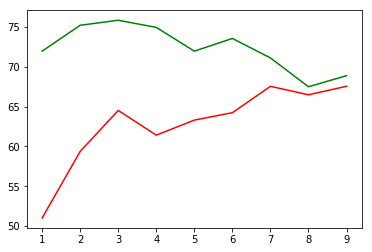

In [46]:
plt.plot(scales, pyr1_scale_linear,'r',scales, pyr2_scale_linear, 'g')
plt.show()

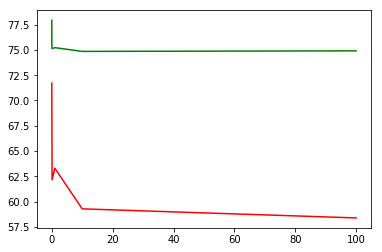

In [42]:
plt.plot(C_range, pyr1_C_linear,'r',C_range, pyr2_C_linear, 'g')
plt.show()

In [41]:
scales = list(range(1,10))
pyr1_scale_RBF = np.zeros(len(scales))
pyr2_scale_RBF = np.zeros(len(scales))

classifier = "RBFSVM"
isDense = True
isPca = False
numClusters = 96
numNeighbours = 27
scale = 2
step = 8
distanceMetric = "euclidean"
numFeatures = 0
splits = 5
pyramid_levels = 2
for i in range(len(scales)):
    pyr1_scale_RBF[i], pyr2_scale_RBF[i] = main(classifier, isDense, isPca, numClusters, numNeighbours, scale, step, distanceMetric, numFeatures, splits)
    print("Scale = ", scales[i], " Piramids lvl 1= ", pyr1_scale_RBF[i], " Piramids lvl 2= ", pyr2_scale_RBF[i])

Scale =  1  Piramids lvl 1=  15.523632214964426  Piramids lvl 2=  74.90127951737556
Scale =  2  Piramids lvl 1=  15.523632214964426  Piramids lvl 2=  76.01344005737022
Scale =  3  Piramids lvl 1=  15.523632214964426  Piramids lvl 2=  77.82304782842542
Scale =  4  Piramids lvl 1=  15.523632214964426  Piramids lvl 2=  75.95631295012885
Scale =  5  Piramids lvl 1=  15.523632214964426  Piramids lvl 2=  71.44014171117024
Scale =  6  Piramids lvl 1=  15.523632214964426  Piramids lvl 2=  72.66624566207236
Scale =  7  Piramids lvl 1=  15.523632214964426  Piramids lvl 2=  70.05554830379408
Scale =  8  Piramids lvl 1=  15.523632214964426  Piramids lvl 2=  69.35425289854155
Scale =  9  Piramids lvl 1=  15.523632214964426  Piramids lvl 2=  68.99813521476703


In [44]:
classifier = "RBFSVM"
isDense = True
isPca = False
numClusters = 96
numNeighbours = 27
scale = 2
step = 8
distanceMetric = "euclidean"
numFeatures = 0
splits = 5
pyramid_levels = 2
C_range = [0.001, 0.01, 0.1, 1, 10, 100]
pyr1_C_RBF = np.zeros(len(C_range))
pyr2_C_RBF = np.zeros(len(C_range))

for i in range(len(C_range)):
    pyr1_C_RBF[i], pyr2_C_RBF[i] = main(classifier, isDense, isPca, numClusters, numNeighbours, scale, step, distanceMetric, numFeatures, splits, C_range[i])
    print("C = ", C_range[i], " Piramids lvl 1= ", pyr1_C_RBF[i], " Piramids lvl 2= ", pyr2_C_RBF[i])

C =  0.001  Piramids lvl 1=  15.523632214964426  Piramids lvl 2=  15.523632214964426
C =  0.01  Piramids lvl 1=  15.523632214964426  Piramids lvl 2=  15.523632214964426
C =  0.1  Piramids lvl 1=  15.523632214964426  Piramids lvl 2=  54.97838379484839
C =  1  Piramids lvl 1=  15.523632214964426  Piramids lvl 2=  76.01344005737022
C =  10  Piramids lvl 1=  15.523632214964426  Piramids lvl 2=  79.0926050142188
C =  100  Piramids lvl 1=  15.523632214964426  Piramids lvl 2=  79.0926050142188


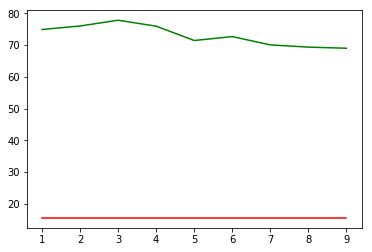

In [47]:
plt.plot(scales, pyr1_scale_RBF,'r',scales, pyr2_scale_RBF, 'g')
plt.show()

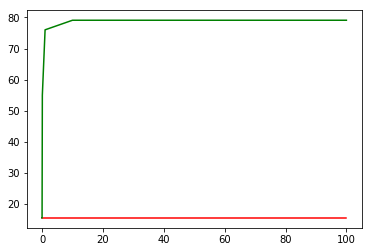

In [48]:
plt.plot(C_range, pyr1_C_RBF,'r',C_range, pyr2_C_RBF, 'g')
plt.show()

In [59]:
scales = list(range(1,10))
pyr1_scale_hist = np.zeros(len(scales))
pyr2_scale_hist = np.zeros(len(scales))

classifier = "histSVM"
isDense = True
isPca = False
numClusters = 96
numNeighbours = 27
scale = 2
step = 8
distanceMetric = "euclidean"
numFeatures = 0
splits = 5
pyramid_levels = 2
for i in range(len(scales)):
    pyr1_scale_hist[i], pyr2_scale_hist[i] = main(classifier, isDense, isPca, numClusters, numNeighbours, scale, step, distanceMetric, numFeatures, splits)
    print("Scale = ", scales[i], " Piramids lvl 1= ", pyr1_scale_hist[i], " Piramids lvl 2= ", pyr2_scale_hist[i])

C:\Users\nilai\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\nilai\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


NameError: name 'GeneralizedHistogramIntersection' is not defined

In [ ]:
classifier = "histSVM"
isDense = True
isPca = False
numClusters = 96
numNeighbours = 27
scale = 2
step = 8
distanceMetric = "euclidean"
numFeatures = 0
splits = 5
pyramid_levels = 2
C_range = [0.001, 0.01, 0.1, 1, 10, 100]
pyr1_C_hist = np.zeros(len(C_range))
pyr2_C_hist = np.zeros(len(C_range))

for i in range(len(C_range)):
    pyr1_C_hist[i], pyr2_C_hist[i] = main(classifier, isDense, isPca, numClusters, numNeighbours, scale, step, distanceMetric, numFeatures, splits, C_range[i])
    print("C = ", C_range[i], " Piramids lvl 1= ", pyr1_C_hist[i], " Piramids lvl 2= ", pyr2_C_hist[i])

In [ ]:
plt.plot(scales, pyr1_scale_hist,'r',scales, pyr2_scale_hist, 'g')
plt.show()

In [ ]:
plt.plot(C_range, pyr1_C_hist,'r',C_range, pyr2_C_hist, 'g')
plt.show()

<h2>Compute a k-means clustering on the descriptor space</h2>

<h3>Function:</h3>
<ul>
    <li><b>numClustersIteration():</b> for each train image, projects each keypoint descriptor to its closest visual word.
    Each of the images is represented with the frequency of each visual word.</li>
</ul>

<h3>Variables:</h3>
<ul>
    <li><b>visual_words:</b> frequency list of all the visual words of the images.</li>
    <li><b>codebook:</b> K-means algorithm implementation with a restricted batch size.</li>

<h2>Build and train a k-nn classifier</h2>

<h3>Function:</h3>
<ul>
    <li><b>numNeighIteration():</b> creates a k-nn classifier and trains it with the train descriptors. Then computes the test descriptors and the accuracy of the model.</li>
</ul>

<h3>Variables:</h3>
<ul>
    <li><b>knn:</b> K Nearest Neighbors classifier with the neighbors and metric specified.</li>
    <li><b>visual_words_test:</b> resulting classification of the algorithm for all the images.</li>
    <li><b>mat_accuracy:</b> accuracy for the different combinations of metrics(k-nn), number of neighbors(k-nn), number of features(SIFT) and number of clusters(k-means).
</ul>

<h2>3D Results</h2>
We have executed the code changing the values of the following variables:
<ul>
    <li><b>k:</b> number of clusters of the k-means algorithm. [2<sup>4</sup>, 2<sup>5</sup>, 2<sup>6</sup>, 2<sup>7</sup>]</li>
    <li><b>neigh:</b> number of neighbours to compare to in the k-nn algorithm. [24, 27, 30, 33]</li>
    <li><b>numFeatures:</b> number of features to take from the SIFT detector. [60, 120, 180, 240]</li>
    <li><b>metric:</b> distance metric to calculate distances from classes on the k-nn algorithm. [euclidean, manhattan, chebyshev, minkowski]</li>
</ul>

The results are ploted as 3D accuracy plots for each number of clusters and features independently with a set of neighbour quantities (X axis) and distance metrics (Y axis).


The best results for number of <i>neighbours</i> was found at <b>30</b>, the ideal number of <i>clusters</i> was arround <b>96</b> with the <b>euclidean</b> <i>metric</i> and the number of <i>features</i> arround <b>300</b>.
<br>
It has to be taken into account that not all possible values of those variables were tried though a better result might exist within the non-tested combination.

<h2>2D results</h2>
To find a most accurate parameters solution we execute the algorithm fixing 3 of the 4 parameters and iterating for a set of values of the other variable.

<h3>Unary Parameter Dependent</h3>

In order to compute the high time complexity emprovements, we implemented a method that only expect to return a unical result given the best combination of parameters, that will help us to manage the results of the Dense SIFT.

<H1> Dense Sift Emprovement</H1>
The difference between SIFT and Dense SIFT is that with dense SIFT you get a  descriptor at every location, while with normal SIFT you get a descriptions at the locations determined by Lowe's algorithm.


<H3>Dense Sift Findings</H3>

As we can see given the best combination of the obtained parameters of the SIFT descriptor already tested, Dense Sift descriptors performs way better, since in SIFT descriptors, the focus is to find the more representative points of the image regardless that most of them are close to each other. So in Dense SIFT descriptors as all the points are sequentially spotted, the information of the less relevant areas of the landscapes are not lost, and you can match easily those landscapes that have low energy frequencies in most of the image but from one small area with others of the same type.